In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime 
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

In [80]:
path="/content/drive/MyDrive/LSTM - 金融商品模型/stock data/水泥/1101台泥.csv"
df = pd.read_csv(path,index_col='date')
df.index = pd.to_datetime(df.index)                           # 將日期轉換成index
print(len(df))                                       # 印出總數據筆數

155


In [81]:
train_periods = 8                                    #訓練資料筆數 ex:每次使用8筆資料進行訓練
test_periods = 8                                     #測試資料筆數 ex:計算出8筆資料
train_data = df[:-test_periods].close.values.reshape(-1,1)
test_data = df[-test_periods:].close.values.reshape(-1,1)

scaler = MinMaxScaler().fit(train_data)                         #資料正規化 轉換為0-1之間的數 
train_scaled = scaler.transform(train_data)                       #value: 0-1
train_scaled = torch.FloatTensor(train_scaled)                      #torch.Size([35, 1])
train_scaled = train_scaled.view(-1)                           #torch.Size([35])

def get_x_y_pairs(train_scaled, train_periods, test_periods):              #將train_data轉換成序列的形式
  x_train = [train_scaled[i:i+train_periods]
              for i in range(len(train_scaled)-train_periods-test_periods+1)]
  y_train = [train_scaled[i+train_periods:i+train_periods+test_periods]
              for i in range(len(train_scaled)-train_periods-test_periods+1)]
  x_train = torch.stack(x_train)
  y_train = torch.stack(y_train)
  return x_train, y_train

x_train, y_train = get_x_y_pairs(train_scaled, train_periods, test_periods)

In [82]:
class LSTM(nn.Module):                              # LSTM神經網路運作盒子
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
    lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden) 
    predictions = self.linear(lstm_out.view(len(x), -1))   
    return predictions[-1]

model = LSTM(input_size=1, hidden_size=100, output_size=test_periods)     #hidden_size 隱藏輸出層
model = model
criterion = nn.MSELoss()                             #宣告優化器(optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)              #宣告損失函數(loss function)

In [19]:
epochs = 2000
model.train()
for epoch in range(1, epochs+1):
  for x, y in zip(x_train, y_train):
    x = x
    y = y
    y_hat = model(x)
    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
        
  if epoch%500==0:
    print(f'epoch: {epoch:10} loss:{loss.item():10.8f}')

torch.save(model.state_dict(), '/content/drive/MyDrive/LSTM - 金融商品模型/模型存放/2330-LSTM_2000epochs.pth')  #儲存訓練模型
print('Finished Training')

epoch:        500 loss:0.01125881
epoch:       1000 loss:0.00080697
epoch:       1500 loss:0.00149657
epoch:       2000 loss:0.00066908
Finished Training


In [83]:
pretrained_dict = torch.load('/content/drive/MyDrive/LSTM - 金融商品模型/模型存放/2317-LSTM_2000epochs.pth')  #讀取訓練完成模型
model_dict = model.state_dict()
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
print("Finish loading parameter.")

Finish loading parameter.


In [132]:
epochs = 500
model.train()
for epoch in range(1, epochs+1):
  for x, y in zip(x_train, y_train):
    x = x
    y = y
    y_hat = model(x)
    optimizer.zero_grad()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()
        
  if epoch%100==0:                                 #每多少epoch跳出一次loss
    print(f'epoch: {epoch:10} loss:{loss.item():10.8f}')

# torch.save(model.state_dict(), '/content/drive/MyDrive/LSTM - 金融商品模型/模型存放/2330test2317-2000es-500.pth')
# print('Finished Training')

epoch:        100 loss:0.00002255
epoch:        200 loss:0.00016691
epoch:        300 loss:0.00008639
epoch:        400 loss:0.00001422
epoch:        500 loss:0.00007914


In [130]:
model.eval()                                      #讓模型不要在預測的時候同時做學習
with torch.no_grad():
    pre = []
    for i in range(len(train_scaled)-train_periods-test_periods+1):
        predictions = model(train_scaled[train_periods+i:train_periods+i+test_periods])
        predictions = predictions.tolist()
        pre.append(predictions[-1])
        p = torch.Tensor(pre)
        i+=1
p=p.view(-1)
p = scaler.inverse_transform(np.array(p.reshape(-1,1)))                # inverse transform -> no scaling    #將正規化後的值變回原本的值
print(p,'\n',len(p))

[[31.199482]
 [31.674791]
 [32.314396]
 [32.209354]
 [31.444593]
 [31.954584]
 [30.106117]
 [27.695292]
 [29.179487]
 [29.045507]
 [30.54514 ]
 [31.384794]
 [31.283373]
 [32.153908]
 [32.043304]
 [31.500679]
 [31.638193]
 [31.651825]
 [32.58155 ]
 [31.968937]
 [31.54937 ]
 [31.907967]
 [32.793816]
 [33.470253]
 [33.37989 ]
 [33.536564]
 [33.523033]
 [35.09663 ]
 [35.476112]
 [36.60318 ]
 [35.978497]
 [35.013657]
 [35.08415 ]
 [35.27677 ]
 [33.64763 ]
 [34.350574]
 [34.02293 ]
 [33.523712]
 [33.675064]
 [33.751945]
 [33.954773]
 [35.063095]
 [35.309784]
 [36.065613]
 [36.247807]
 [35.68493 ]
 [35.67615 ]
 [35.68999 ]
 [35.887928]
 [35.578506]
 [34.936752]
 [33.648834]
 [33.33293 ]
 [33.889137]
 [34.632977]
 [34.640526]
 [35.300476]
 [35.47918 ]
 [35.273174]
 [38.52195 ]
 [38.789867]
 [38.733013]
 [40.70853 ]
 [43.78386 ]
 [43.04904 ]
 [43.62435 ]
 [41.022594]
 [42.295944]
 [42.004593]
 [42.623165]
 [42.443188]
 [42.172516]
 [41.96485 ]
 [41.350063]
 [42.680065]
 [42.46875 ]
 [43.55798 ]

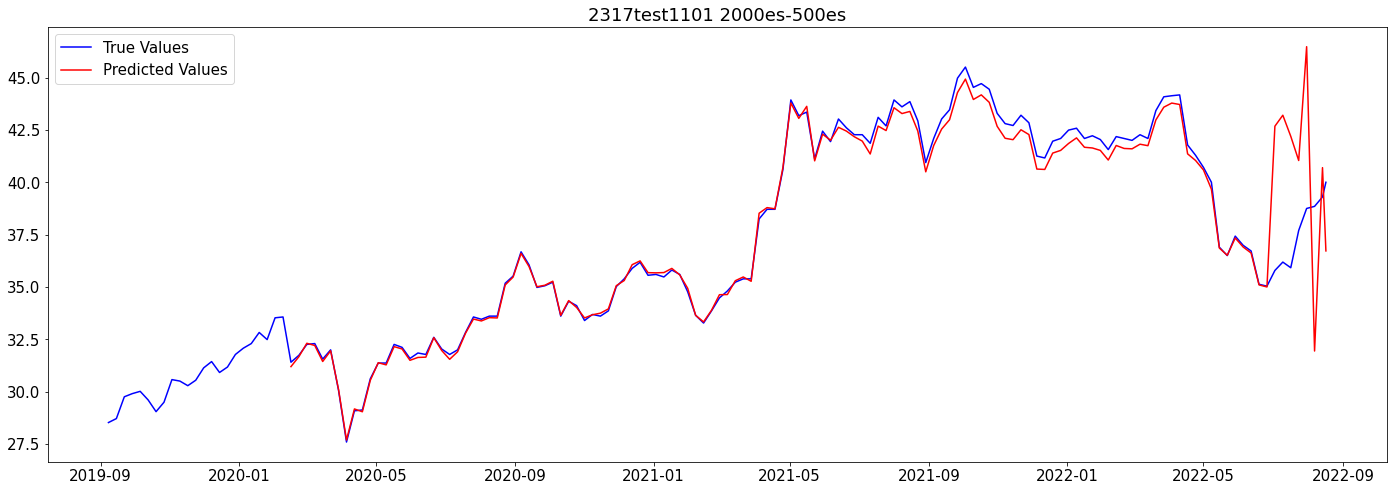

In [131]:
x = [datetime.datetime.date(d) for d in df.index]   #時間
font = {'size':15}                    #字體大小
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(24,8))
plt.title('2317test1101 2000es-500es')                     #標題
# plt.ylabel('close')                    #Y軸
# plt.grid(True)                      #是否需要網格狀
plt.plot(x, df.close, "b-", label='True Values')
plt.plot(x[-len(p):], p, "r-", label='Predicted Values')
plt.legend()